## Q1

In [1]:
# Q1
import pandas as pd
import pymc as pm
import numpy as np
import arviz as az
import matplotlib.pyplot as plt

url = "https://media.geeksforgeeks.org/wp-content/uploads/20240522154350/Fish[1].csv"
fish_data0 = pd.read_csv(url)
print(fish_data0.describe())
y_weight = np.array(fish_data0["Weight"])
y_weight = (y_weight > np.median(y_weight))*1
fish_data = fish_data0.drop("Weight", axis = 1)
fish_data = fish_data.drop("Species", axis = 1)

fish_data[["Length1", "Length2", "Length3", "Height", "Width"]] = fish_data[["Length1", "Length2", "Length3", "Height", "Width"]].subtract(fish_data[["Length1", "Length2", "Length3", "Height", "Width"]].mean())
fish_data = pd.concat([pd.DataFrame([1]*fish_data.shape[0]), fish_data], axis = 1)
print(fish_data.head())
X = np.matrix(fish_data)
n, p = X.shape


            Weight     Length1     Length2     Length3      Height       Width
count   159.000000  159.000000  159.000000  159.000000  159.000000  159.000000
mean    398.326415   26.247170   28.415723   31.227044    8.970994    4.417486
std     357.978317    9.996441   10.716328   11.610246    4.286208    1.685804
min       0.000000    7.500000    8.400000    8.800000    1.728400    1.047600
25%     120.000000   19.050000   21.000000   23.150000    5.944800    3.385650
50%     273.000000   25.200000   27.300000   29.400000    7.786000    4.248500
75%     650.000000   32.700000   35.500000   39.650000   12.365900    5.584500
max    1650.000000   59.000000   63.400000   68.000000   18.957000    8.142000
   0  Length1   Length2   Length3    Height     Width
0  1 -3.04717 -3.015723 -1.227044  2.549006 -0.397486
1  1 -2.24717 -2.115723 -0.027044  3.509006 -0.111886
2  1 -2.34717 -1.915723 -0.127044  3.406806  0.278614
3  1  0.05283  0.584277  2.272956  3.759006  0.038014
4  1  0.25283  0.58

In [2]:
with pm.Model() as LR:
    betas = pm.Normal('betas', mu=0, sigma=1, shape=p)
    y = pm.Bernoulli('y', p=1/(1+pm.math.exp(-X@betas)), observed=y_weight)
    
with LR:
    idata = pm.sample()
    
az.summary(idata, round_to=5)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [betas]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.
There were 43 divergences after tuning. Increase `target_accept` or reparameterize.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
betas[0],0.76957,0.52917,-0.19660,1.77000,0.00961,0.00696,3006.66356,2276.84806,1.00097
betas[1],0.55974,0.76308,-0.81394,2.04403,0.01746,0.01235,1921.34604,1451.77888,1.00187
betas[2],0.48392,0.79036,-0.97330,2.00475,0.01988,0.01623,1575.09386,1570.62554,1.00388
betas[3],0.01734,0.51252,-0.95127,0.98122,0.01233,0.00872,1736.49951,2086.01636,1.00355
betas[4],1.07604,0.42273,0.30692,1.90752,0.00992,0.00702,1802.34669,2161.53619,1.00164
betas[5],1.40691,0.83436,-0.15182,2.97761,0.01633,0.01174,2618.20512,2466.00231,1.00173


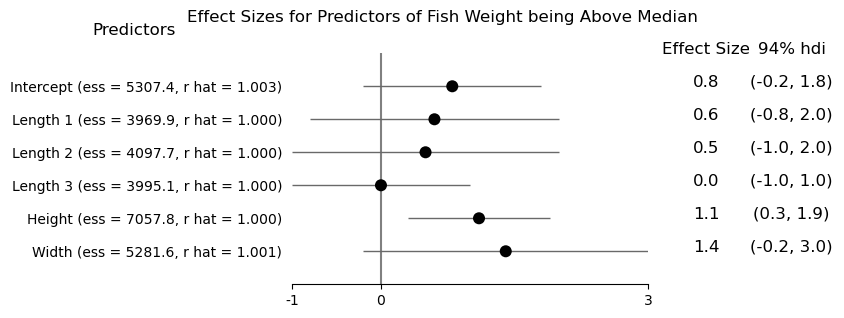

In [5]:
import matplotlib.image as mpimg
import zepid
from zepid.graphics import EffectMeasurePlot

summ = az.summary(idata, round_to=1)

labs = ["Intercept (ess = 3006.7, r hat = 1.001)",
        "Length 1 (ess = 1921.3, r hat = 1.002)",
        "Length 2 (ess = 1575.1, r hat = 1.004)",
        "Length 3 (ess = 1736.5, r hat = 1.004)",
        "Height (ess = 1802.3, r hat = 1.002)",
       "Width (ess = 2618.2, r hat = 1.002)"]
measure = list(summ["mean"])
lower = list(summ["hdi_3%"])
upper = list(summ["hdi_97%"])
pt = EffectMeasurePlot(label=labs, effect_measure=measure, lcl=lower, ucl=upper)
pt.labels(effectmeasure='Odds Ratio', conf_int = "94% hdi", center = 0)
pt.colors(pointshape="o")
ax=pt.plot(figsize=(7,3), t_adjuster=0.09, max_value=3, min_value=-1)
plt.title("Odds ratios for Predictors of Fish Weight being Above Median",loc="center",x=-1.3, y=1.1)
plt.suptitle("Predictors",x=-0.1,y=0.98)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(False)
plt.show()

Only increase in fish height significantly increases the odds that the weight of the fish is above the 50th percentile. 

The $\hat r$'s of all sets of sampling chains are all close to 1, indicating okay priors and enough samples were specified to allow for similar sampling chains. The bulk effective sample sizes are smaller than the 4 000 total draws, suggesting inefficient sampling. The tail effective sample sizes are also only around 35-63% of the magnitude of the 4 000 total draws. In fact, the tail effective sample sizes for sampling the odds raio of Length 3 and Height are larger than their bulk effective sample size. This suggests that the bulk of these distriutions is very concentrated and therefore correlated, while the tails of these sampling distribuions are comparably broad.

## Q2

In [19]:
# Q2
import pandas as pd
import pymc as pm
import numpy as np
import arviz as az
import matplotlib.pyplot as plt
from sklearn.utils import resample


url = "https://media.geeksforgeeks.org/wp-content/uploads/20240522154350/Fish[1].csv"
fish_data = pd.read_csv(url)

print(fish_data.describe())

fish_data[["Weight", "Height", "Width"]] = fish_data[["Weight", "Height", "Width"]].subtract(fish_data[["Weight", "Height", "Width"]].mean())
fish_data = pd.get_dummies(fish_data, columns=["Species"], prefix='', prefix_sep='', drop_first=True, dtype = int)
fish_data = pd.concat([pd.DataFrame([1]*fish_data.shape[0]), fish_data], axis = 1)
print(fish_data.head())

down10 = resample(fish_data,
             replace=True,
             n_samples=10,
             random_state=365)
down50 = resample(fish_data,
             replace=True,
             n_samples=50,
             random_state=365)
down100 = resample(fish_data,
             replace=True,
             n_samples=100,
             random_state=365)
y_lens = np.array(down50[["Length1", "Length2", "Length3"]])
fish_data = down50.drop(["Length1", "Length2", "Length3"], axis = 1)
X = np.matrix(fish_data)

            Weight     Length1     Length2     Length3      Height       Width
count   159.000000  159.000000  159.000000  159.000000  159.000000  159.000000
mean    398.326415   26.247170   28.415723   31.227044    8.970994    4.417486
std     357.978317    9.996441   10.716328   11.610246    4.286208    1.685804
min       0.000000    7.500000    8.400000    8.800000    1.728400    1.047600
25%     120.000000   19.050000   21.000000   23.150000    5.944800    3.385650
50%     273.000000   25.200000   27.300000   29.400000    7.786000    4.248500
75%     650.000000   32.700000   35.500000   39.650000   12.365900    5.584500
max    1650.000000   59.000000   63.400000   68.000000   18.957000    8.142000
   0      Weight  Length1  Length2  Length3    Height     Width  Parkki  \
0  1 -156.326415     23.2     25.4     30.0  2.549006 -0.397486       0   
1  1 -108.326415     24.0     26.3     31.2  3.509006 -0.111886       0   
2  1  -58.326415     23.9     26.5     31.1  3.406806  0.278614 

In [21]:
def mvn_reg(X = X, y = y_lens):
    n,p = X.shape
    m = y.shape[1]
    a_cov = np.cov(np.transpose(y))

    with pm.Model() as MNV_LKJ:

        packed_L = pm.LKJCholeskyCov("packed_L", n=m, eta=2.0, 
                                     sd_dist=pm.Exponential.dist(1.0, shape=m), 
                                     compute_corr=False)
        L = pm.expand_packed_triangular(m, packed_L)
        betas = pm.Normal('betas', mu=0, sigma=1, shape=(p,m))
        Sigma = pm.Deterministic('Sigma', L.dot(L.T))
        y = pm.MvNormal('y', mu=X@betas, chol=L, observed=y)   

        idata = pm.sample()

    az.summary(idata, round_to=5)
    return idata

In [3]:
"""y_lens = np.array(down10[["Length1", "Length2", "Length3"]])
fish_data = down10.drop(["Length1", "Length2", "Length3"], axis = 1)
X = np.matrix(fish_data)
mvn_reg()"""
y_lens = np.array(down50[["Length1", "Length2", "Length3"]])
fish_data = down50.drop(["Length1", "Length2", "Length3"], axis = 1)
X = np.matrix(fish_data)
idata = mvn_reg()
"""y_lens = np.array(down50[["Length1", "Length2", "Length3"]])
fish_data = down50.drop(["Length1", "Length2", "Length3"], axis = 1)
X = np.matrix(fish_data)
mvn_reg()"""

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [packed_L, betas]


/opt/conda/lib/python3.11/site-packages/pytensor/compile/function/types.py:970: RuntimeWarning: invalid value encountered in accumulate
  self.vm()
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6222 seconds.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.


'y_lens = np.array(down50[["Length1", "Length2", "Length3"]])\nfish_data = down50.drop(["Length1", "Length2", "Length3"], axis = 1)\nX = np.matrix(fish_data)\nmvn_reg()'

In [26]:
az.summary(idata, round_to = 5)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"Sigma[0, 0]",298.71484,39.93290,230.39903,377.24453,0.66867,0.86745,3863.80510,2437.96149,1.00025
"Sigma[0, 1]",320.91435,42.19908,244.82448,399.56614,0.71880,0.93364,3750.34568,2245.42033,1.00036
"Sigma[0, 2]",336.77678,44.10976,259.16639,420.89564,0.75394,0.97625,3719.86911,2141.95708,1.00029
"Sigma[1, 0]",320.91435,42.19908,244.82448,399.56614,0.71880,0.93364,3750.34568,2245.42033,1.00036
"Sigma[1, 1]",344.91859,45.44475,259.36353,426.00235,0.78252,1.00023,3667.53173,2243.87341,1.00043
"Sigma[1, 2]",361.99331,47.56242,275.55609,450.21679,0.81886,1.04966,3669.68418,2191.02840,1.00034
"Sigma[2, 0]",336.77678,44.10976,259.16639,420.89564,0.75394,0.97625,3719.86911,2141.95708,1.00029
"Sigma[2, 1]",361.99331,47.56242,275.55609,450.21679,0.81886,1.04966,3669.68418,2191.02840,1.00034
"Sigma[2, 2]",380.20716,51.34049,289.53779,478.57793,0.87273,1.09580,3764.11189,2312.91108,1.00027
"betas[0, 0]",0.27348,0.68125,-0.94389,1.57366,0.00915,0.01043,5542.34081,3544.66872,0.99979


For samplings of 10 + 2 types of parameters, with 3 outcomes the (estimated) time it takes to complete the sampling is:

10 observations: 23min (wow, that's long)

50 observations: 110min

100 observations: probably 240min  (I didn't let this run to completion)

The sampling times seem to scale linearly with the number of data observations given, suggesting low set-up cost and that the 23min it took for only n = 10 was mostly dedicated towards sampling. I also wouldn't expect sampling time to be much more efficient than linear with respect to the number of data observations due to the inherently expensive nature of most matrix operations.
However, the time to run the same job varies greatly and is probably due to jupyterhub's resource availability.

In [22]:
y_lens = np.array(down10[["Length1", "Length2"]])
fish_data = down10.drop(["Length1", "Length2", "Length3"], axis = 1)
X = np.matrix(fish_data)
idat = mvn_reg()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [packed_L, betas]


/opt/conda/lib/python3.11/site-packages/pytensor/compile/function/types.py:970: RuntimeWarning: invalid value encountered in accumulate
  self.vm()
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1070 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 740 divergences after tuning. Increase `target_accept` or reparameterize.


In [23]:
az.summary(idat, round_to = 5)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"Sigma[0, 0]",144.41868,35.25750,87.37296,203.45519,3.53267,1.32602,121.48942,901.72431,1.02544
"Sigma[0, 1]",156.83592,37.20287,99.45655,227.10326,4.40753,2.29561,97.64099,308.46981,1.03128
"Sigma[1, 0]",156.83592,37.20287,99.45655,227.10326,4.40753,2.29561,97.64099,308.46981,1.03128
"Sigma[1, 1]",173.47495,42.28384,107.43344,252.08227,5.13659,2.68516,91.18677,173.82782,1.03315
"betas[0, 0]",0.73380,0.97032,-1.03632,2.73450,0.01783,0.02822,2812.14487,1904.79010,1.04079
"betas[0, 1]",0.72509,0.98275,-1.01690,2.67905,0.03083,0.02344,1020.43812,1590.16902,1.02492
"betas[1, 0]",-0.00777,0.01559,-0.03675,0.01937,0.00097,0.00027,271.89479,1863.77027,1.01576
"betas[1, 1]",-0.00990,0.01697,-0.04176,0.01918,0.00116,0.00028,229.04596,1603.68079,1.01942
"betas[2, 0]",0.76050,0.80800,-0.79369,2.05189,0.11311,0.06372,57.76720,50.24009,1.04682
"betas[2, 1]",0.91540,0.90496,-0.90981,2.37666,0.14314,0.08972,47.91301,34.46479,1.05561


For samplings of 10 + 2 types of parameters, with 10 given observations the (estimated) time it takes to complete the sampling is:

3 outcomes: 23min

2 outcomes: 17min

The $\hat{r}$'s for 2 outcomes are larger than those for 3 outcomes. The effective sample sizes for 2 outcomes are also very small, along with none of the predictors having significant betas. This suggests that having few outcomes is not very suitable for multivariate regression as it provides more unstable estimates and doesn't change the sampling time much.

In [24]:
"""y_lens = np.array(down10[["Length1", "Length2"]])
fish_data = down10.drop(["Length1", "Length2", "Length3", "Parkki", "Perch", "Pike"], axis = 1)
X = np.matrix(fish_data)
mvn_reg()"""
y_lens = np.array(down10[["Length1", "Length2"]])
fish_data = down10.drop(["Length1", "Length2", "Length3", "Parkki", "Perch", "Pike", "Roach", "Smelt", "Whitefish"], axis = 1)
X = np.matrix(fish_data)
idat = mvn_reg()


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [packed_L, betas]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 882 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 1743 divergences after tuning. Increase `target_accept` or reparameterize.


In [25]:
az.summary(idat, round_to = 5)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"Sigma[0, 0]",144.08583,27.25254,90.52027,189.19843,2.15793,3.97231,98.42619,572.31681,1.40665
"Sigma[0, 1]",153.97311,28.28777,99.65723,201.62849,2.53592,3.96564,103.44771,709.01468,1.31869
"Sigma[1, 0]",153.97311,28.28777,99.65723,201.62849,2.53592,3.96564,103.44771,709.01468,1.31869
"Sigma[1, 1]",166.92843,33.37459,112.65493,232.35620,5.37995,4.29634,51.14992,566.14155,1.28071
"betas[0, 0]",0.19531,1.23278,-1.59847,2.06364,0.47451,0.09208,6.88979,17.19196,1.56488
"betas[0, 1]",0.74619,0.80614,-0.81051,2.50101,0.05708,0.11978,103.15224,371.07753,1.35810
"betas[1, 0]",-0.00373,0.01398,-0.03351,0.01615,0.00376,0.00060,16.13933,641.61674,1.16919
"betas[1, 1]",-0.00479,0.01542,-0.03742,0.01525,0.00435,0.00076,13.78384,458.26174,1.20744
"betas[2, 0]",0.82338,0.54268,-0.16645,2.06930,0.03583,0.06999,107.51789,599.25596,1.13390
"betas[2, 1]",0.95009,0.59050,-0.10449,2.25911,0.03123,0.08538,215.39832,526.65101,1.27926


For samplings with 10 given observations and 2 outcomes the (estimated) time it takes to complete the sampling is:

10 + 2 types of parameters: 17min

7 + 2 types of parameters: 16min

4 + 2 types of parameters: 14min

The sampling times don't seem to scale much with the number of parameters to sample. For fewer predictors, the $\hat r$'s are also pretty big, suggesting poor chain convergence. Perhaps for this data set, all of the covariates should be considered to provide stable samples of their effect on fish lengths.

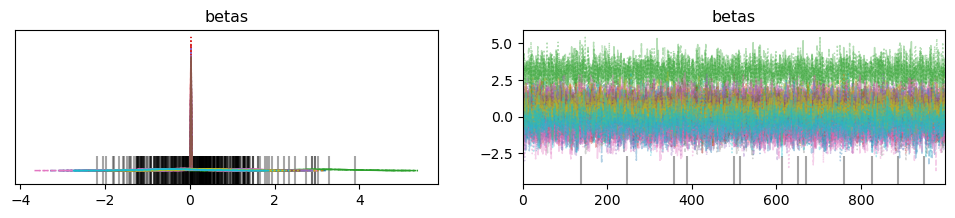

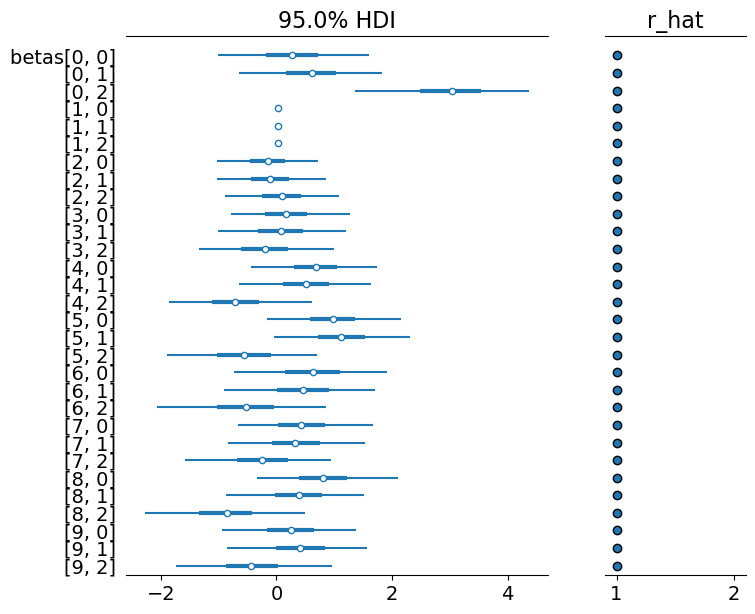

In [77]:
# using 10+2 parameters, 3 outcomes, 50 observations
az.plot_trace(idata,var_names='betas')
az.summary(idata, round_to = 5)
az.plot_forest(idata, var_names = "betas", filter_vars = "like",
               combined=True, hdi_prob=0.95, r_hat=True);

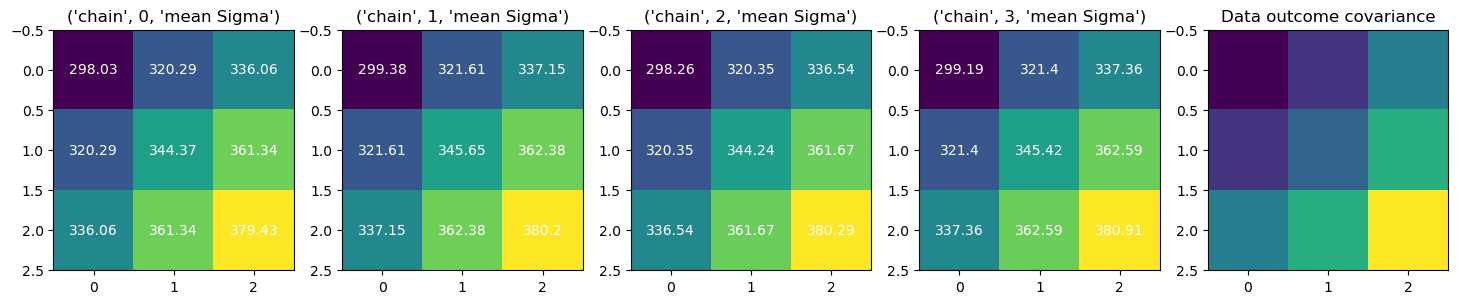

In [76]:
fig,ax = plt.subplots(1,5,figsize=(18,4))
a_cov = np.cov(np.transpose(y_lens)) 

ax[-1].imshow(a_cov)
ax[-1].set_title(("Data outcome covariance"))
ax[0].set_title(("Sigma used to generate y"))
for chain in range(4):
    ax[chain].imshow(idata.posterior['Sigma'].mean(axis=1)[chain])
    for i in range(3):
        for j in range(3):
            ax[chain].text(i,j,str(round(idata.posterior['Sigma'].mean(axis=1)[chain].values[j,i],2)),
                             c='w', ha='center', va='center')
    ax[chain].set_title(("chain",chain,"mean Sigma"))

Only weight is significantly related to all of Length1,2,3, with its 94% credible interval being above 0. However, the effect size is quite small. The estimated sigma matrices for all chains seem to agree well with each other and the actual outcome data.
The histogram of the betas' sampled distributions has a huge spike at 0. This spike is the distribution of the weight effect sizes. It is unusual to have such a concentrated distribution from only 50 data points, suggesting the prior for the weight effect size reflects the data very well or that we should further investigate the relationship between fish weight and lengths.


The $\hat{r}$s of all sets of sampling chains are close to 1, indicating okay priors and enough samples were specified to allow for similar sampling chains. The bulk effective sample sizes are close to the 4 000 total draws, suggesting acceptable sampling efficiency. The tail effective sample sizes are also small, but this is expected.

## Q3

In [38]:
# Q3

import pandas as pd
import pymc as pm
import numpy as np
import arviz as az
import matplotlib.pyplot as plt
from sklearn.utils import resample


url = "https://media.geeksforgeeks.org/wp-content/uploads/20240522154350/Fish[1].csv"
fish_data = pd.read_csv(url)
fish_data["Weight"] = (fish_data["Weight"].values > np.median(fish_data["Weight"].values))*1
print(fish_data.describe())

fish_data[["Length1", "Length2", "Length3", "Height", "Width"]] = fish_data[["Length1", "Length2", "Length3", "Height", "Width"]]\
.subtract(fish_data[["Length1", "Length2", "Length3", "Height", "Width"]].mean())
fish_data[["Length1", "Length2", "Length3", "Height", "Width"]] = fish_data[["Length1", "Length2", "Length3", "Height", "Width"]]/np.std(fish_data[["Length1", "Length2", "Length3", "Height", "Width"]], axis = 0)
fish_data = pd.get_dummies(fish_data, columns=["Species"], prefix='', prefix_sep='', drop_first=True, dtype = int)
fish_data = pd.concat([pd.DataFrame([1]*fish_data.shape[0]), fish_data], axis = 1)
print(fish_data.head())

down10 = resample(fish_data,
             replace=False,
             n_samples=10,
             random_state=365)
down50 = resample(fish_data,
             replace=False,
             n_samples=50,
             random_state=365)
down100 = resample(fish_data,
             replace=False,
             n_samples=100,
             random_state=365)

y_spec = np.array(down10[["Weight",  "Parkki", "Perch",  "Pike"]])
fish_data = down10.drop(["Weight",  "Parkki", "Perch",  "Pike", "Roach",  "Smelt",  "Whitefish"], axis = 1)
X = np.matrix(fish_data)


           Weight     Length1     Length2     Length3      Height       Width
count  159.000000  159.000000  159.000000  159.000000  159.000000  159.000000
mean     0.496855   26.247170   28.415723   31.227044    8.970994    4.417486
std      0.501570    9.996441   10.716328   11.610246    4.286208    1.685804
min      0.000000    7.500000    8.400000    8.800000    1.728400    1.047600
25%      0.000000   19.050000   21.000000   23.150000    5.944800    3.385650
50%      0.000000   25.200000   27.300000   29.400000    7.786000    4.248500
75%      1.000000   32.700000   35.500000   39.650000   12.365900    5.584500
max      1.000000   59.000000   63.400000   68.000000   18.957000    8.142000
   0  Weight   Length1   Length2   Length3    Height     Width  Parkki  Perch  \
0  1       0 -0.305789 -0.282303 -0.106020  0.596579 -0.236529       0      0   
1  1       1 -0.225507 -0.198054 -0.002337  0.821261 -0.066579       0      0   
2  1       1 -0.235542 -0.179332 -0.010977  0.797341  0

In [39]:
def mv_class(X = X, y = y_spec):
    n,p = X.shape
    m = y.shape[1]

    with pm.Model() as GLM:

        L,R,std = pm.LKJCholeskyCov("R", n=m, eta=2, 
                                    sd_dist=pm.Exponential.dist(1, shape=m), 
                                    compute_corr=True)
        betas = pm.Normal('betas', mu=0, sigma=1, shape=(p,m))
        z = pm.MvNormal('z', mu=X@betas,  cov=R) #cov=Sigma
        # the probit is the inverse cdf of a standard normal
        # the inverse probit is the cdf of a standard normal
        y = pm.Bernoulli('y', p=pm.math.invprobit(z), observed=y)   
        # Integrating out z would give:
        #y = pm.Bernoulli('y', p=pm.math.invprobit(X@betas), observed=x)   
        try:
            idata_glm = pm.sample(target_accept=0.9)
        except:
            GLM.debug()
    
    az.summary(idata_glm, round_to=5)
    return idata_glm

In [40]:
#changing number of input observations

# 10 obs
idata_mvc = mv_class()

# 50 obs
"""y_spec = np.array(down50[["Weight",  "Parkki", "Perch",  "Pike", "Roach",  "Smelt",  "Whitefish"]])
fish_data = down50.drop(["Weight",  "Parkki", "Perch",  "Pike", "Roach",  "Smelt",  "Whitefish"], axis = 1)
X = np.matrix(fish_data)
idata_mvc = mv_class()

# 100 obs
y_spec = np.array(down100[["Weight",  "Parkki", "Perch",  "Pike", "Roach",  "Smelt",  "Whitefish"]])
fish_data = down100.drop(["Weight",  "Parkki", "Perch",  "Pike", "Roach",  "Smelt",  "Whitefish"], axis = 1)
X = np.matrix(fish_data)
mv_class()"""

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [R, betas, z]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2183 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
There were 1197 divergences after tuning. Increase `target_accept` or reparameterize.
/opt/conda/lib/python3.11/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/opt/conda/lib/python3.11/site-packages/arviz/stats/diagnostics.py:991: RuntimeWarning: invalid value encountered in scalar divide
  varsd = varvar / evar / 4


'y_spec = np.array(down50[["Weight",  "Parkki", "Perch",  "Pike", "Roach",  "Smelt",  "Whitefish"]])\nfish_data = down50.drop(["Weight",  "Parkki", "Perch",  "Pike", "Roach",  "Smelt",  "Whitefish"], axis = 1)\nX = np.matrix(fish_data)\nidata_mvc = mv_class()\n\n# 100 obs\ny_spec = np.array(down100[["Weight",  "Parkki", "Perch",  "Pike", "Roach",  "Smelt",  "Whitefish"]])\nfish_data = down100.drop(["Weight",  "Parkki", "Perch",  "Pike", "Roach",  "Smelt",  "Whitefish"], axis = 1)\nX = np.matrix(fish_data)\nmv_class()'

In [63]:
az.summary(idata_mvc, round_to = 5)


/opt/conda/lib/python3.11/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/opt/conda/lib/python3.11/site-packages/arviz/stats/diagnostics.py:991: RuntimeWarning: invalid value encountered in scalar divide
  varsd = varvar / evar / 4


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
R[0],1.01068,1.04667,0.00015,2.87292,0.02330,0.03400,1709.86808,1252.65509,1.00237
R[1],-0.03151,0.56026,-1.07836,1.00924,0.01843,0.03931,984.95678,780.79530,1.00061
R[2],0.96068,0.95389,0.02019,2.67302,0.02464,0.02759,940.85769,948.34384,1.00080
R[3],-0.11097,0.54371,-1.22430,0.89912,0.01689,0.02923,1201.78749,1134.24627,1.00174
R[4],-0.02270,0.53541,-1.16050,1.06754,0.02031,0.02944,868.04342,770.49713,1.00769
...,...,...,...,...,...,...,...,...,...
"z[8, 3]",-1.92242,1.11694,-4.05174,0.08262,0.02807,0.01889,1623.80799,2026.44123,1.00103
"z[9, 0]",-2.89556,1.43954,-5.57619,-0.31496,0.04417,0.03052,1103.55507,1185.26785,1.00276
"z[9, 1]",-2.05205,1.30714,-4.37437,0.33332,0.03943,0.02757,1100.26701,1170.20930,1.00097
"z[9, 2]",0.47030,0.97593,-1.39116,2.30744,0.02540,0.01747,1489.80223,1757.19842,1.00206


For 4 outcomes and 5 + 3 type of parameters to estimate:

10 observations: 37min

50 observations: too long

100 observations: too long

I would've liked to have compared the model's stability for more observations, but sometimes better results aren't worth it due to time and resource consumption.

In [49]:
#changing number of outcomes

"""# 7 outcomes
y_spec = np.array(down10[["Weight",  "Parkki", "Perch",  "Pike", "Roach",  "Smelt",  "Whitefish"]])
fish_data = down10.drop(["Weight",  "Parkki", "Perch",  "Pike", "Roach",  "Smelt",  "Whitefish"], axis = 1)
X = np.matrix(fish_data)
mv_class()"""

"""# 4 outcomes
y_spec = np.array(down10[["Weight",  "Parkki", "Perch",  "Pike"]])
fish_data = down10.drop(["Weight",  "Parkki", "Perch",  "Pike", "Roach",  "Smelt",  "Whitefish"], axis = 1)
X = np.matrix(fish_data)
idata_mvc = mv_class()"""

# 2 outcomes
y_spec = np.array(down10[["Weight", "Pike"]])
fish_data = down10.drop(["Weight",  "Parkki", "Perch",  "Pike", "Roach",  "Smelt",  "Whitefish"], axis = 1)
X = np.matrix(fish_data)
idat = mv_class()
az.summary(idat)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [R, betas, z]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1673 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 1814 divergences after tuning. Increase `target_accept` or reparameterize.
/opt/conda/lib/python3.11/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/opt/conda/lib/python3.11/site-packages/arviz/stats/diagnostics.py:991: RuntimeWarning: invalid value encountered in scalar divide
  varsd = varvar / evar / 4
/opt/conda/lib/python3.11/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: inv

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
R[0],1.581,1.473,0.001,4.286,0.553,0.269,10.0,31.0,1.31
R[1],-0.022,0.443,-0.962,0.801,0.016,0.039,880.0,905.0,1.37
R[2],0.721,0.879,0.017,2.264,0.169,0.033,8.0,18.0,1.42
R[3],-0.148,0.465,-1.147,0.629,0.017,0.027,76.0,777.0,1.04
R[4],0.021,0.486,-0.959,0.821,0.025,0.030,47.0,996.0,1.07
...,...,...,...,...,...,...,...,...,...
"z[8, 3]",-1.457,1.349,-3.683,0.438,0.437,0.102,10.0,19.0,1.32
"z[9, 0]",-3.496,1.805,-6.217,-0.672,0.571,0.145,12.0,52.0,1.24
"z[9, 1]",-2.257,1.261,-4.203,0.162,0.250,0.032,29.0,863.0,1.09
"z[9, 2]",0.371,0.864,-1.397,1.958,0.050,0.093,281.0,389.0,1.15


For 10 data observations and 5 + 3 type of parameters to estimate:

7 outcomes: 48min

4 outcomes: 37min

2 outcomes: 33min



In [73]:
#changing number of parameters

"""# 5 + 3 params
y_spec = np.array(down10[["Weight",  "Parkki", "Perch",  "Pike"]])
fish_data = down10.drop(["Weight",  "Parkki", "Perch",  "Pike", "Roach",  "Smelt",  "Whitefish"], axis = 1)
X = np.matrix(fish_data)
mv_class()

# 3 + 3 params
y_spec = np.array(down10[["Weight",  "Parkki", "Perch",  "Pike"]])
fish_data = down10.drop(["Weight",  "Parkki", "Perch",  "Pike", "Roach",  "Smelt",  "Whitefish", "Length1", "Length2"], axis = 1)
X = np.matrix(fish_data)
mv_class()"""

# 1 + 3 params
y_spec = np.array(down10[["Weight",  "Parkki", "Perch",  "Pike"]])
fish_data = down10.drop(["Weight",  "Parkki", "Perch",  "Pike", "Roach",  "Smelt",  "Whitefish", \
                         "Length1", "Length2", "Length3", "Height"], axis = 1)
X = np.matrix(fish_data)
az.summary(mv_class(), round_to = 5)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [R, betas, z]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2077 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 1194 divergences after tuning. Increase `target_accept` or reparameterize.
/opt/conda/lib/python3.11/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/opt/conda/lib/python3.11/site-packages/arviz/stats/diagnostics.py:991: RuntimeWarning: invalid value encountered in scalar divide
  varsd = varvar / evar / 4
/opt/conda/lib/python3.11/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: inv

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
R[0],0.96372,0.98396,0.00063,2.74486,0.02030,0.02809,2184.36096,1446.41288,1.00417
R[1],-0.02019,0.51028,-1.01970,1.09445,0.01635,0.02438,579.04383,1181.95357,1.00967
R[2],0.95234,0.88500,0.02383,2.60141,0.02166,0.02429,1527.37742,1142.56444,1.03846
R[3],-0.12296,0.51066,-1.19132,0.85333,0.01643,0.02886,1057.25255,1015.22970,1.01711
R[4],-0.01668,0.51901,-1.04762,0.98555,0.01691,0.03297,1119.57807,1080.98888,1.00951
...,...,...,...,...,...,...,...,...,...
"z[8, 3]",-1.97053,1.09688,-3.93262,0.17950,0.03296,0.01849,1101.60477,1834.44162,1.00877
"z[9, 0]",-2.78781,1.48340,-5.69575,-0.20280,0.06146,0.02927,618.01676,1338.52840,1.00963
"z[9, 1]",-2.04617,1.22068,-4.36346,0.18979,0.03620,0.02404,1194.89208,1598.16612,1.02598
"z[9, 2]",0.38055,0.95153,-1.34933,2.21249,0.02378,0.01851,1596.24448,1701.17927,1.00505


For 4 outcomes and 10 data observations:

5 + 3 types of parameters to estimate: 66min

3 + 3 types of parameters: 59min

1 + 3 types of parameters: 55min

The ess of some samples is quite small, but the $\hat r$'s aren't huge. This suggests that these samples are quite stable across chains.

array([[<Axes: title={'center': 'betas'}>,
        <Axes: title={'center': 'betas'}>]], dtype=object)

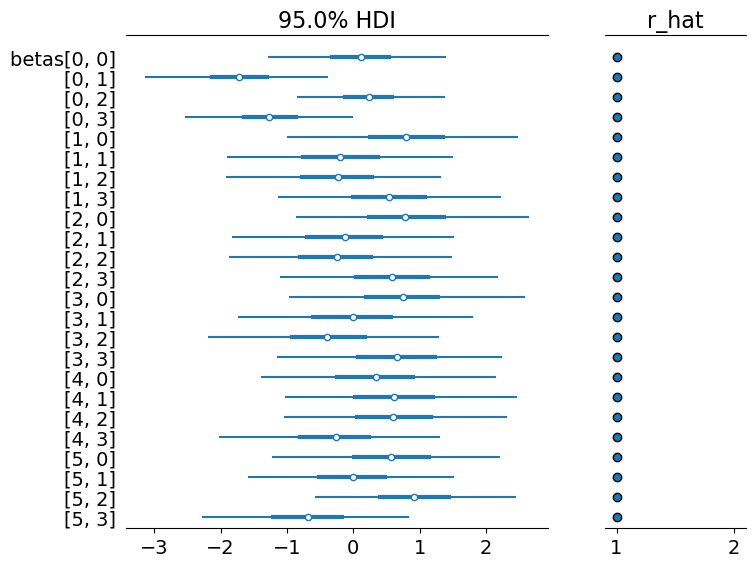

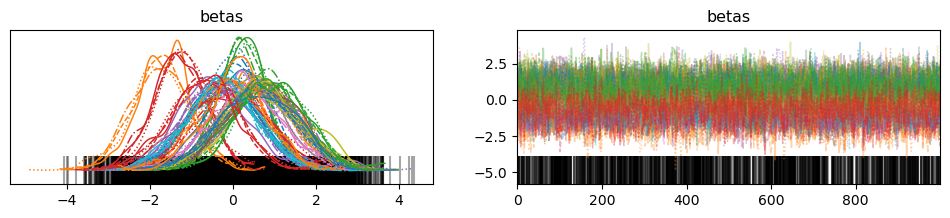

In [64]:
# using 50 obs, 7 outcomes, 5 + 3 params
az.plot_forest(idata_mvc, var_names = "betas", filter_vars = "like",
               combined=True, hdi_prob=0.95, r_hat=True)
az.plot_trace(idata_mvc, var_names='betas')

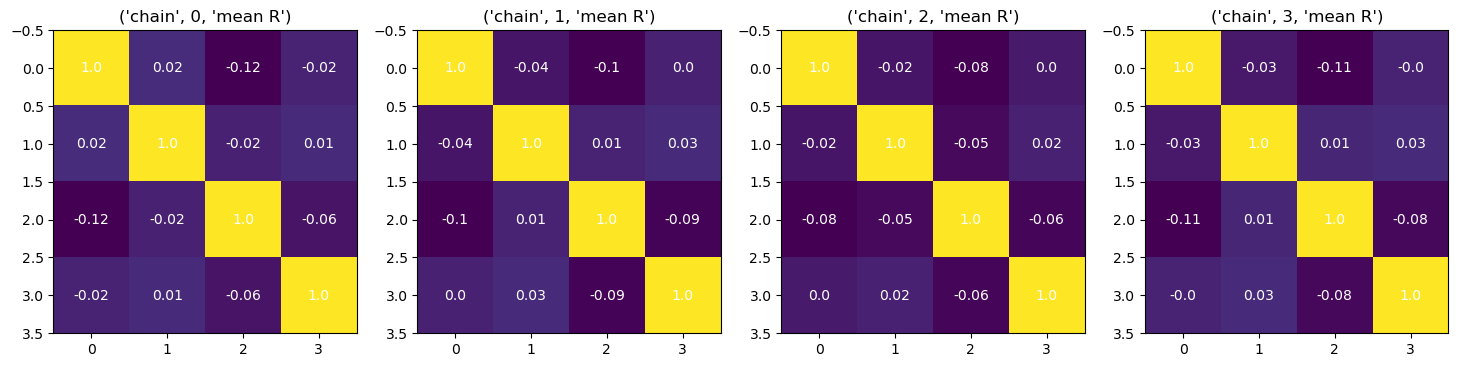

In [71]:
fig,ax = plt.subplots(1,4,figsize=(18,8))
for chain in range(4):
    ax[chain].imshow(idata_mvc.posterior['R_corr'].mean(axis=1)[chain])
    for i in range(4):
        for j in range(4):
            ax[chain].text(i,j,str(round(idata_mvc.posterior['R_corr'].mean(axis=1)[chain].values[j,i],2)),
                             c='w', ha='center', va='center')
    ax[chain].set_title(("chain",chain,"mean R"))
    

The only betas that are significant at the 5% credible level are the intercepts for predicting if the fish is a Parkki or Pike, meanign these fish are less likely to have average width, lengths, and height. The posterior residual correlation matrices agree across chains. The largest magnitude off diagonal correltion is between the residuals of binarized weight (above or below median weight) and whether the fish is a Perch. This may be a reasonable inference since Perch tend to be smaller/lighter fish.

The $\hat r$'s of all sets of sampling chains are all close to 1, indicating okay priors and enough samples were specified to allow for similar sampling chains. The bulk effective sample sizes are around 25% of the 4 000 total draws, suggesting inefficient sampling. The tail effective sample sizes are also of a similar or slightly larger than the bulk effective sample sizes. This suggests that the bulk of these distriutions is very concentrated and therefore correlated, while the tails of these sampling distribuions are comparably broad.